In [1]:
#step 5+6
import pandas as pd
import json
import urllib.parse
import requests as rq
import base64
import geocoder
import pandas as pd
import networkx as nx
import geopandas as gpd
import osmnx as ox
import folium
from shapely.geometry import Point, Polygon
from IPython.display import Image
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

city = "Barcelona, Barcelona, Spain"
location = geocoder.arcgis(city)
latitude = location.lat
longitude = location.lng

%matplotlib inline
ox.__version__

'1.4.0'

In [2]:
#Loading shapefiles with buildings and scraped real estate data
gdf1 = gpd.read_file(r'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/BCN_buildings.gpkg', encoding='utf-8')

gdf2 = gpd.read_file(r'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/fotocasa_2018_3.shp')
# gdf2.to_crs(25831, inplace=True)

In [18]:
gdf1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69595 entries, 0 to 69594
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gml_id      69595 non-null  object  
 1   beginLifes  69595 non-null  object  
 2   conditionO  69595 non-null  object  
 3   beginning   69595 non-null  object  
 4   end         69595 non-null  object  
 5   endLifespa  15 non-null     object  
 6   informatio  69595 non-null  object  
 7   reference   69595 non-null  object  
 8   localId     69595 non-null  object  
 9   namespace   69595 non-null  object  
 10  horizontal  69595 non-null  float64 
 11  horizont_1  69595 non-null  object  
 12  horizont_2  69595 non-null  object  
 13  referenceG  69595 non-null  int64   
 14  currentUse  69518 non-null  object  
 15  numberOfBu  69595 non-null  int64   
 16  numberOfDw  69595 non-null  int64   
 17  numberOfFl  0 non-null      float64 
 18  documentLi  69595 non-null  object  
 

In [3]:
G = ox.graph_from_place(city, simplify=True, retain_all=True, network_type="all")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
print(gdf_nodes.shape, gdf_edges.shape)

(78428, 6) (221157, 19)


Text(0.5, 1.0, 'BUILDINGS')

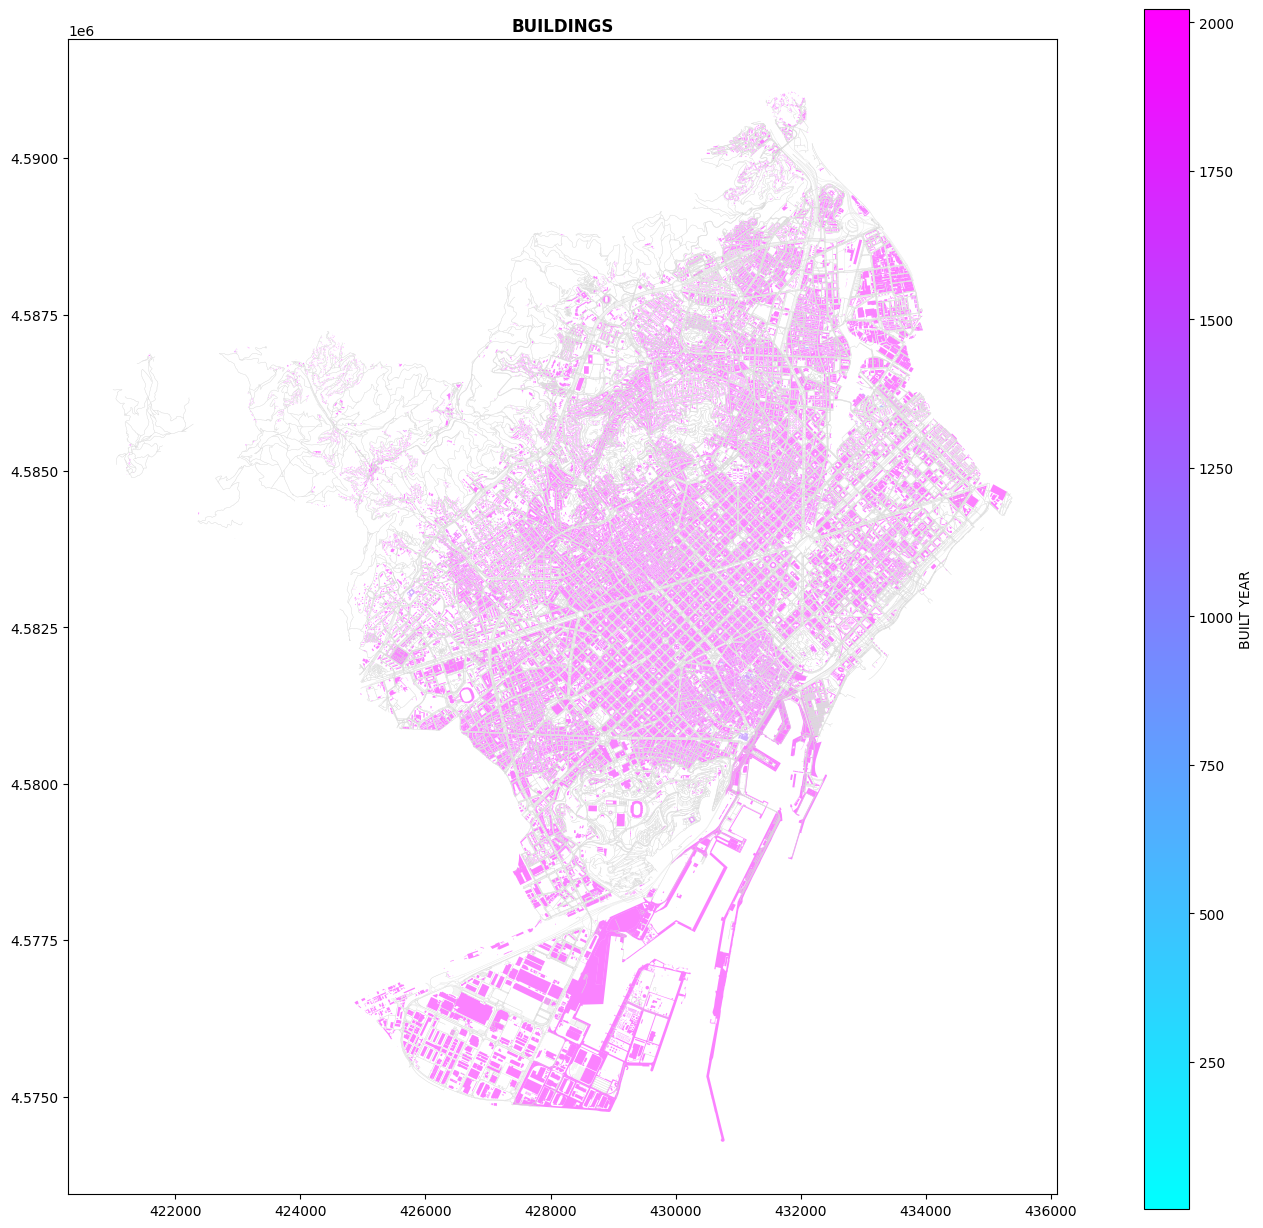

In [15]:
gdf_edges.to_crs(25831, inplace=True)
fig, ax = plt.subplots(figsize=(15, 15))
totcol = cm.cool
gdf_edges.plot(ax=ax, color='gainsboro', linewidth=0.2)
gdf1.plot(column="year", cmap=totcol, ax=ax, alpha=0.5)
# # Create a colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])

sm = plt.cm.ScalarMappable(cmap=totcol)
sm.set_array(gdf1["year"])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("BUILT YEAR")
ax.set_title("BUILDINGS", fontsize=12, fontweight='bold')

In [29]:
colors = cm.cool(np.linspace(0, 1, 4))
colors

array([[0.        , 1.        , 1.        , 1.        ],
       [0.33333333, 0.66666667, 1.        , 1.        ],
       [0.66666667, 0.33333333, 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ]])

In [41]:
current_year - 301

1722

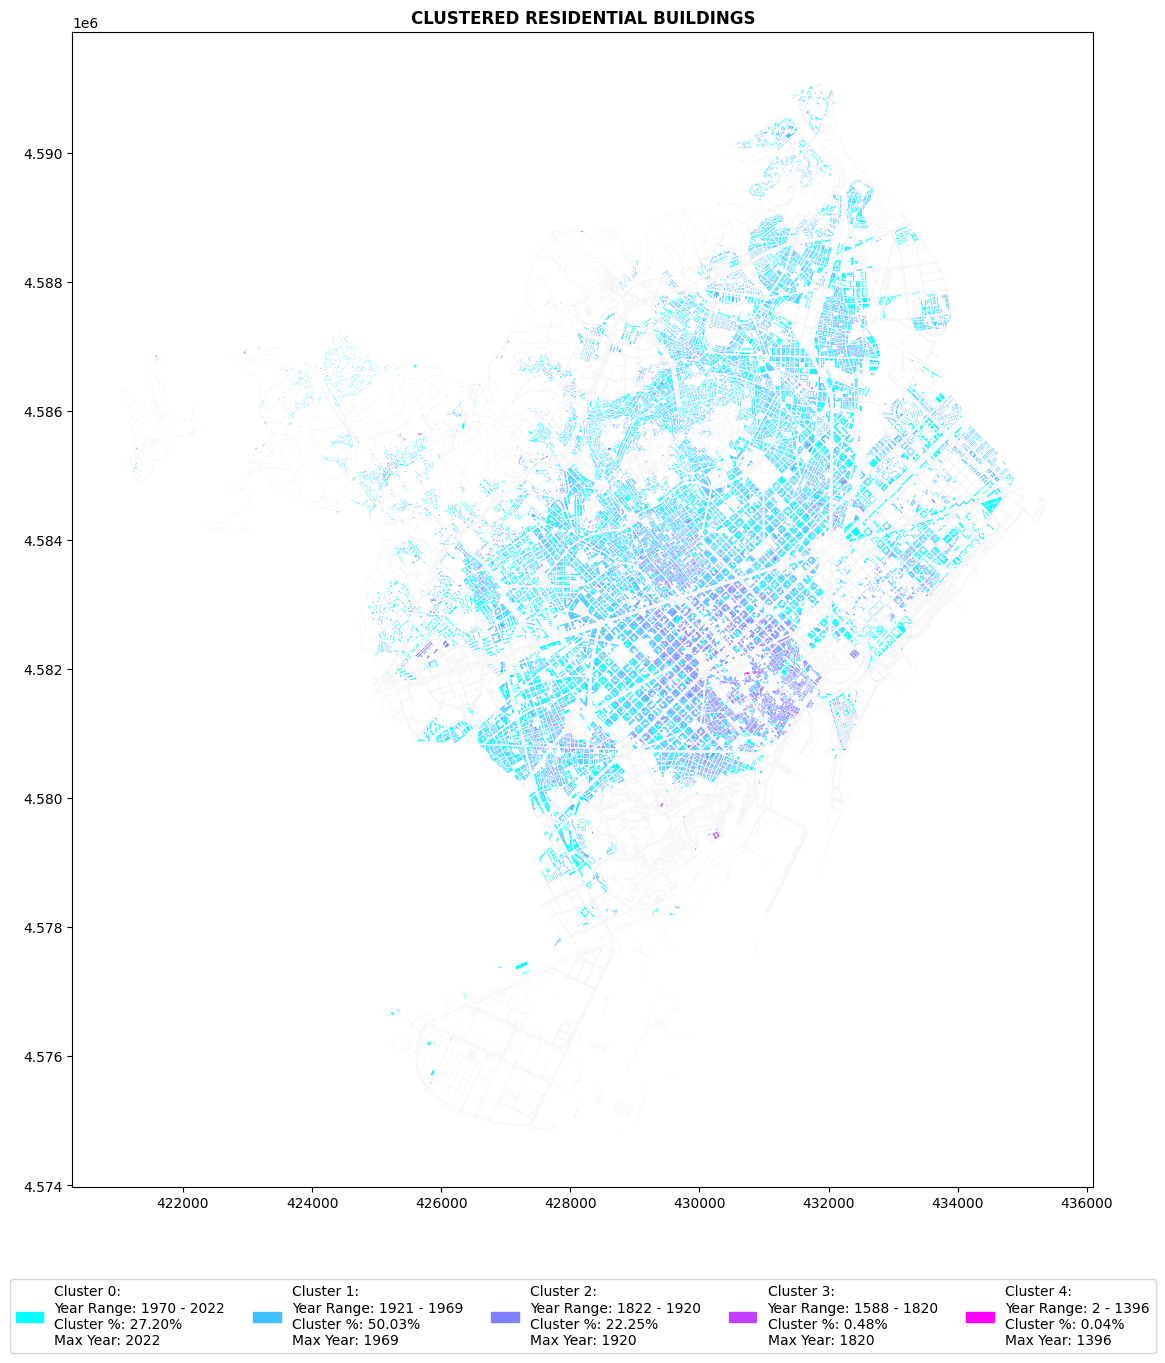

In [55]:
import matplotlib.patches as mpatches

# Step 1: Filter gdf1 by "CurrentUse" containing 'residential' and ignore NaN values
gdf11 = gdf1[gdf1["currentUse"].str.contains('residential', na=False)].copy()

# Step 2: Make clusters by year ranges
current_year = 2023  # Replace with the current year
conditions = [
    gdf11["year"] >= 1970,
    gdf11["year"].between(1921, 1969),
    gdf11["year"].between(1821, 1920),
    gdf11["year"].between(1521, 1820),
    gdf11["year"] <= 1520
]
choices = [0, 1, 2, 3, 4]
gdf11["cluster"] = np.select(conditions, choices, default=-1)

# Step 3: Check CRS and convert to EPSG 25831 if necessary
if gdf11.crs is None or gdf11.crs.to_epsg() != 25831:
    gdf11 = gdf11.to_crs(25831)

# Step 4: Plot gdf11 with each cluster represented by a different color
fig, ax = plt.subplots(figsize=(15, 15))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2) 
cluster_colors = cm.cool(np.linspace(0, 1, len(choices)))
gdf11.plot(column='cluster', cmap=cm.colors.ListedColormap(cluster_colors), ax=ax, legend=False)

# Step 5: Add legend below the graph with rectangles for each cluster color and corresponding information
legend_patches = []
for i, color in enumerate(cluster_colors):
    cluster_data = gdf11[gdf11["cluster"] == i]
    year_range = f"{cluster_data['year'].min()} - {cluster_data['year'].max()}"
    cluster_percentage = len(cluster_data) / len(gdf11) * 100
    max_year = cluster_data['year'].max()
    label = f"Cluster {i}:\nYear Range: {year_range}\nCluster %: {cluster_percentage:.2f}%\nMax Year: {max_year}"
    patch = mpatches.Patch(color=color, label=label)
    legend_patches.append(patch)

# Display the legend below the graph
plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(choices))

# Step 6: Add title and display the plot
ax.set_title("CLUSTERED RESIDENTIAL BUILDINGS", fontsize=12, fontweight='bold')
plt.axis('on')
plt.show()

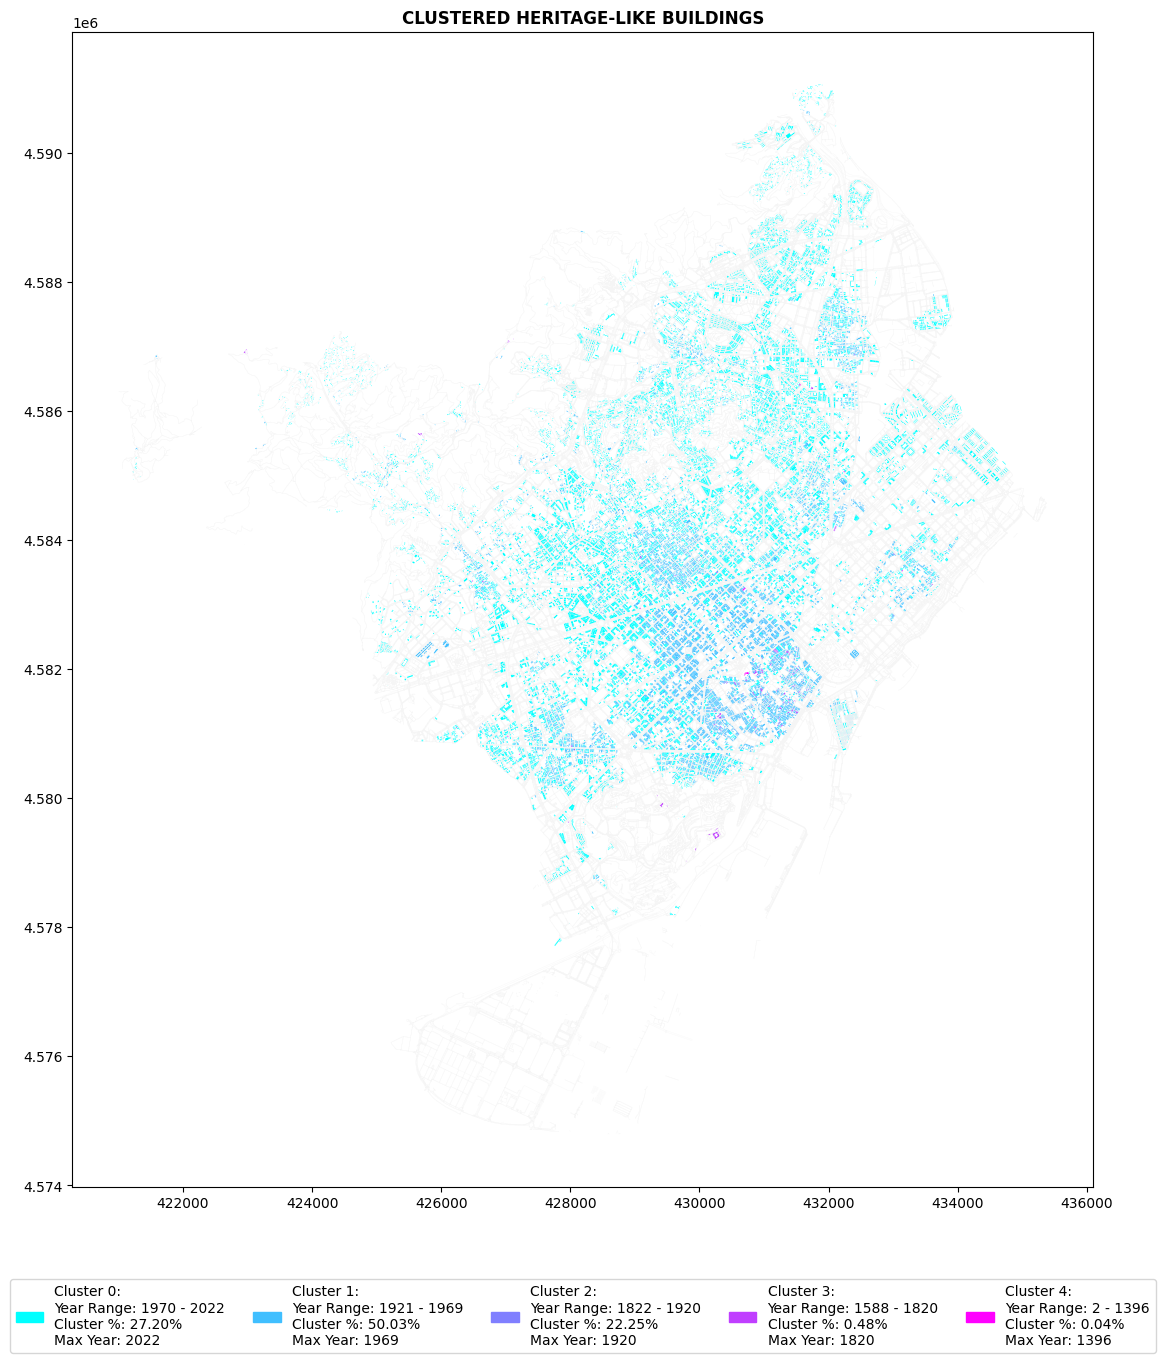

In [106]:
# Step 4: Plot gdf11 with each cluster represented by a different color
gdf22 = gdf11
fig, ax = plt.subplots(figsize=(15, 15))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2) 
cluster_colors = cm.cool(np.linspace(0, 1, len(choices)))
gdf22[gdf22["cluster"] > 0].plot(column='cluster', cmap=cm.colors.ListedColormap(cluster_colors), ax=ax, legend=False)

# Step 5: Add legend below the graph with rectangles for each cluster color and corresponding information
legend_patches = []
for i, color in enumerate(cluster_colors):
    cluster_data = gdf22[gdf22["cluster"] == i]
    year_range = f"{cluster_data['year'].min()} - {cluster_data['year'].max()}"
    cluster_percentage = len(cluster_data) / len(gdf22) * 100
    max_year = cluster_data['year'].max()
    label = f"Cluster {i}:\nYear Range: {year_range}\nCluster %: {cluster_percentage:.2f}%\nMax Year: {max_year}"
    patch = mpatches.Patch(color=color, label=label)
    legend_patches.append(patch)

# Display the legend below the graph
plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(choices))

# Step 6: Add title and display the plot
ax.set_title("CLUSTERED HERITAGE-LIKE BUILDINGS", fontsize=12, fontweight='bold')
plt.axis('on')
plt.show()

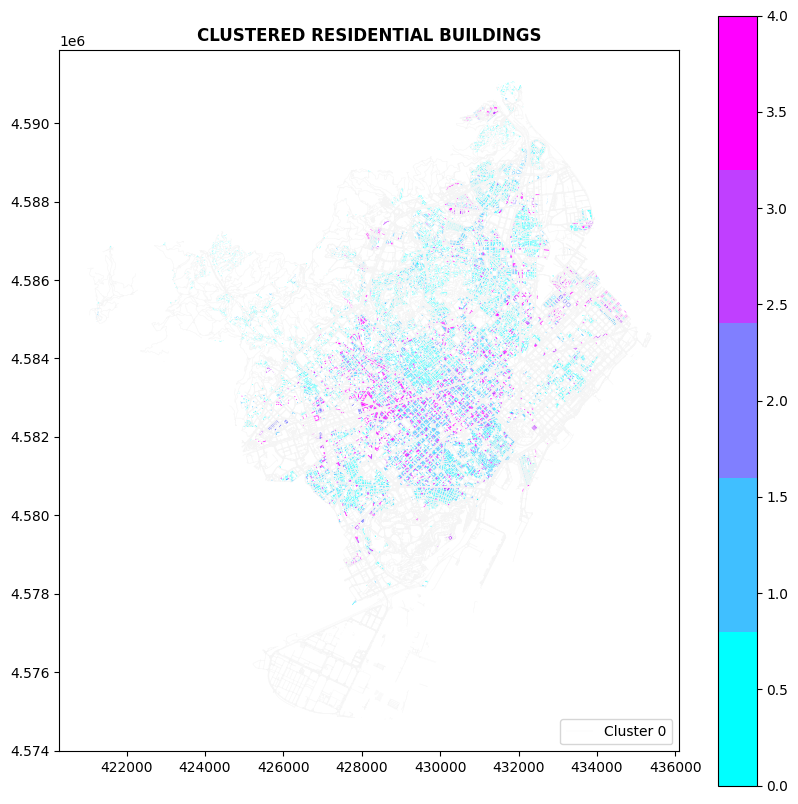

In [56]:
import pandas as pd
from sklearn.cluster import KMeans

# Filter gdf11 by cluster larger than 0
gdf12 = gdf11[gdf11["cluster"] > 0].copy()

# Select columns for clustering
columns_to_cluster = ['year', 'numberOfDw', 'value']
X = gdf12[columns_to_cluster].values

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
gdf12['kmeans_cluster'] = kmeans.fit_predict(X)

# Step 4: Plot gdf12 with each cluster represented by a different color
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2)
cluster_colors = cm.cool(np.linspace(0, 1, len(set(gdf12['kmeans_cluster']))))
gdf12.plot(column='kmeans_cluster', cmap=cm.colors.ListedColormap(cluster_colors), ax=ax, legend=True)

# Step 5: Customize the legend to show the cluster labels
legend_labels = []
for cluster_id in sorted(set(gdf12['kmeans_cluster'])):
    cluster_data = gdf12[gdf12['kmeans_cluster'] == cluster_id]
    label = f"Cluster {cluster_id}"
    legend_labels.append(label)
ax.legend(legend_labels, loc='lower right')

# Step 6: Add title and display the plot
ax.set_title("CLUSTERED RESIDENTIAL BUILDINGS", fontsize=12, fontweight='bold')
plt.show()

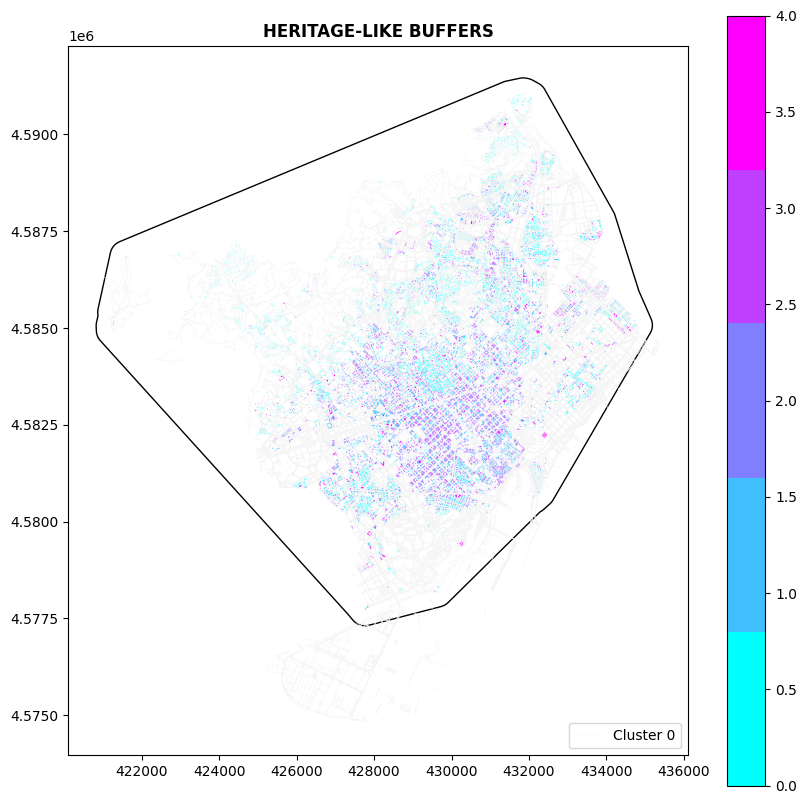

In [109]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Step 6: Perform clustering using KMeans
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
gdf12['kmeans_cluster'] = kmeans.fit_predict(X)

# Step 7: Create convex hulls for each cluster
clusters = gdf12.groupby('kmeans_cluster')
convex_hulls = []
for cluster_id, cluster_data in clusters:
    cluster_points = cluster_data['geometry'].unary_union
    convex_hull = cluster_points.convex_hull
    convex_hulls.append(convex_hull)

# Step 8: Apply buffers to convex hulls
buffers = [convex_hull.buffer(400) for convex_hull in convex_hulls]

# Step 9: Dissolve buffers
dissolved = gpd.GeoSeries(buffers).unary_union

# Step 10: Plot gdf12 with convex hull buffers
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2)
cluster_colors = cm.cool(np.linspace(0, 1, len(set(gdf12['kmeans_cluster']))))
gdf12.plot(column='kmeans_cluster', cmap=cm.colors.ListedColormap(cluster_colors), ax=ax, legend=True)
gpd.GeoSeries(dissolved).plot(ax=ax, edgecolor='black', facecolor='none')

# Step 11: Customize the legend to show the cluster labels
legend_labels = []
for cluster_id in sorted(set(gdf12['kmeans_cluster'])):
    cluster_data = gdf12[gdf12['kmeans_cluster'] == cluster_id]
    label = f"Cluster {cluster_id}"
    legend_labels.append(label)
ax.legend(legend_labels, loc='lower right')

# Step 12: Add title and display the plot
ax.set_title("HERITAGE-LIKE BUFFERS", fontsize=12, fontweight='bold')
plt.show()

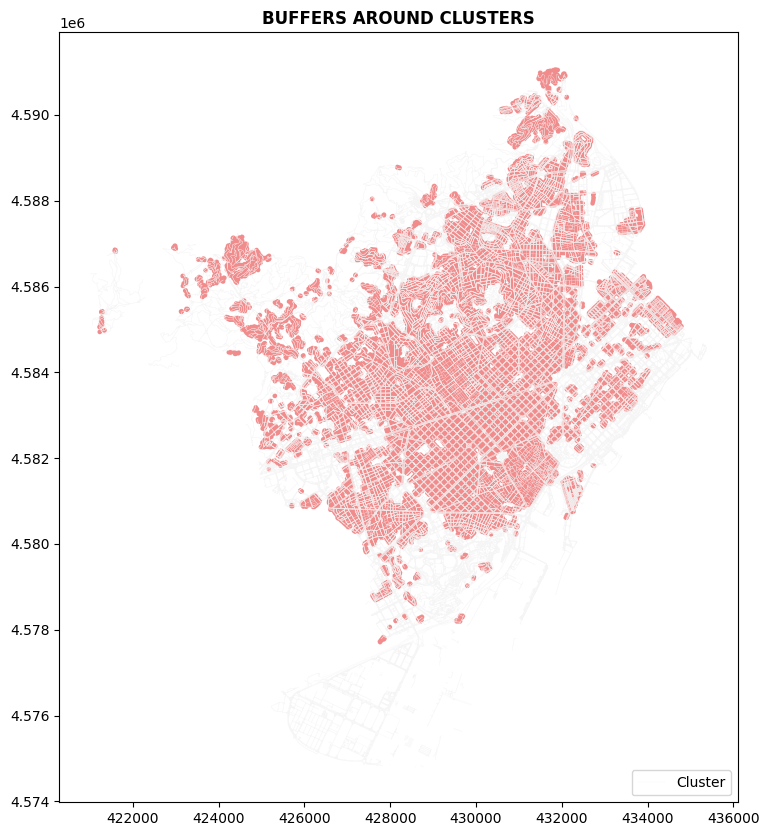

In [112]:
# Step 1: Filter gdf22 by "cluster" larger than 0
gdf33 = gdf22[gdf22["cluster"] > 0].copy()

# Step 2: Create buffers around each polygon
buffers = gdf33["geometry"].buffer(50)

# Step 3: Dissolve buffers per each unique "cluster"
dissolved_buffer = buffers.unary_union

# Step 4: Plot the dissolved buffer with different colors and alpha=0.5
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(dissolved_buffer).plot(ax=ax, color=cm.Set1(np.linspace(0, 1, 1)), alpha=0.5)
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2)
# Step 5: Customize the legend to show the cluster label
ax.legend(["Cluster"], loc="lower right")

# Step 6: Add title and display the plot
ax.set_title("BUFFERS AROUND CLUSTERS", fontsize=12, fontweight='bold')
plt.show()

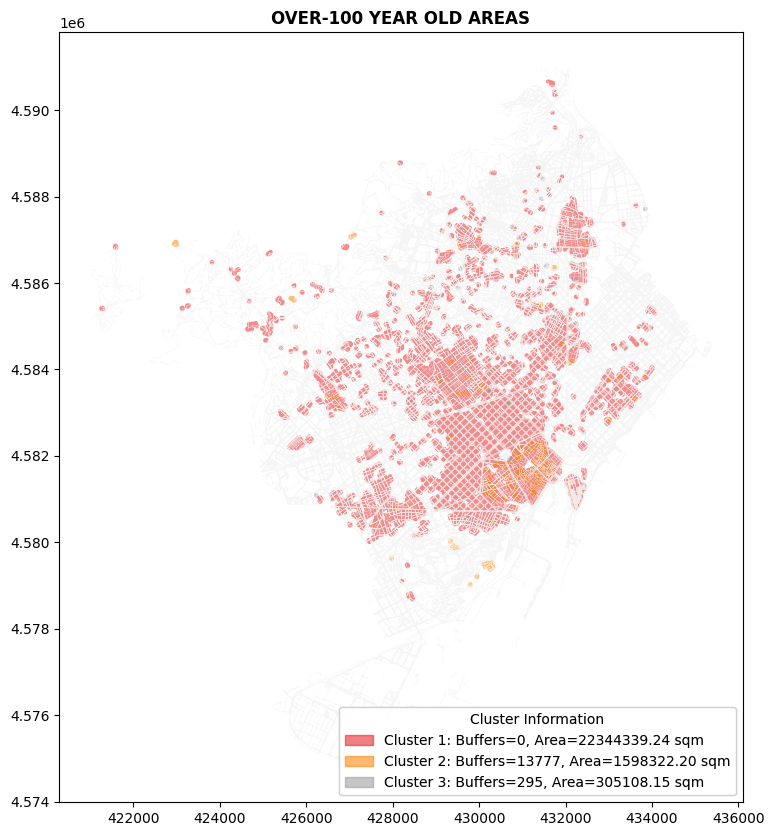

In [121]:
from shapely.ops import unary_union
# Step 1: Filter gdf22 by "cluster" larger than 1
gdf33 = gdf22[gdf22["cluster"] > 1].copy()

# Step 2: Create buffers around each polygon
buffers = gdf33["geometry"].buffer(50)

# Step 3: Dissolve buffers per each unique "cluster"
dissolved_buffers = []
for cluster_id, cluster_data in gdf33.groupby("cluster"):
    cluster_buffers = buffers[cluster_data.index]
    dissolved_buffer = unary_union(cluster_buffers)
    dissolved_buffers.append(dissolved_buffer)

# Step 5: Customize the legend to show the cluster labels, number of buffers, and area
legend_labels = []
for i, dissolved_buffer in enumerate(dissolved_buffers):
    cluster_num = i + 1
    num_buffers = len(gdf33[gdf33["cluster"] == cluster_num])
    area = dissolved_buffer.area
    legend_labels.append(f"Cluster {cluster_num}: Buffers={num_buffers}, Area={area:.2f} sqm")

# Create a custom legend
legend_handles = []
for dissolved_buffer, color in zip(dissolved_buffers, cm.Set1(np.linspace(0, 1, len(dissolved_buffers)))):
    legend_handles.append(mpatches.Patch(color=color, alpha=0.5))

# Step 6: Plot the dissolved buffers with different colors and alpha=0.5
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2)
for dissolved_buffer, color in zip(dissolved_buffers, cm.Set1(np.linspace(0, 1, len(dissolved_buffers)))):
    gpd.GeoSeries(dissolved_buffer).plot(ax=ax, color=color, alpha=0.5)

# Add the custom legend below the plot
legend = ax.legend(legend_handles, legend_labels, loc="lower right", title="Cluster Information")
ax.add_artist(legend)

# Step 7: Add title and display the plot
ax.set_title("OVER-100 YEAR OLD AREAS", fontsize=12, fontweight='bold')
plt.show()

In [122]:
gdf3 = gpd.read_file(r'C:/WORK_IAAC/submissions/Data Science III/datascience_III_src/5_clusterprices.shp')
# gdf2.to_crs(25831, inplace=True)

In [124]:
gdf3.head()

Cluster                                           geometry
0        0  MULTIPOLYGON (((428244.204 4585902.701, 428240...
1        1  MULTIPOLYGON (((434704.998 4584761.727, 434701...
2        2  MULTIPOLYGON (((434167.408 4584671.075, 434166...
3        3  MULTIPOLYGON (((434299.470 4583793.162, 434299...
4        4  MULTIPOLYGON (((435010.831 4584652.833, 435010...

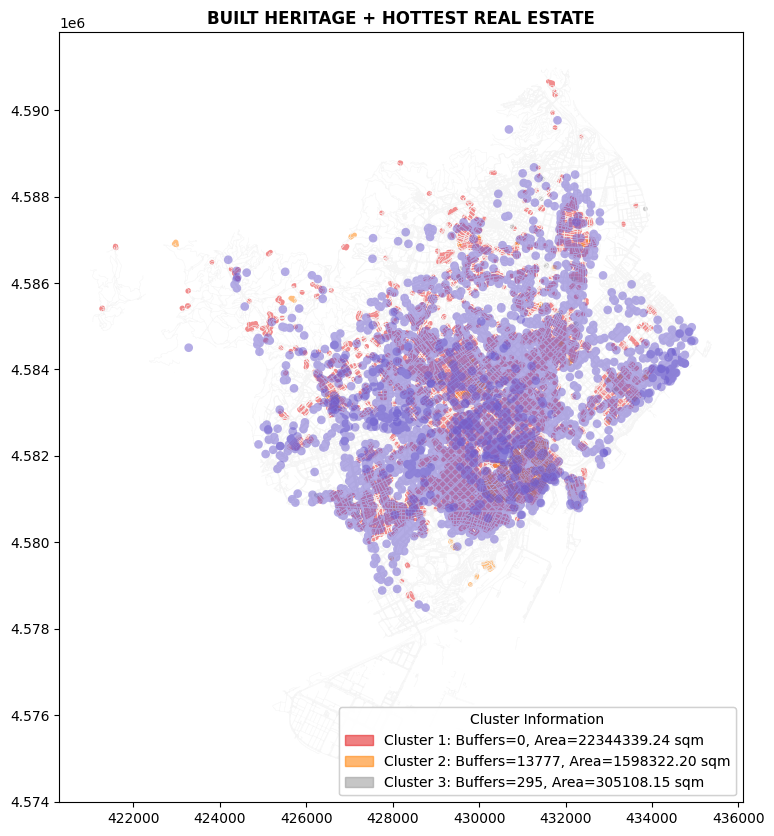

In [127]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(ax=ax, color='whitesmoke', linewidth=0.2, zorder=2)

# Filter gdf3 by 'Cluster' 
gdf3_filtered = gdf3[gdf3['Cluster'] > 1]

# Plot the filtered gdf3 with color = 'blue' and alpha = 0.5
gdf3_filtered.plot(ax=ax, color='slateblue', alpha=0.5, zorder=3)

for dissolved_buffer, color in zip(dissolved_buffers, cm.Set1(np.linspace(0, 1, len(dissolved_buffers)))):
    gpd.GeoSeries(dissolved_buffer).plot(ax=ax, color=color, alpha=0.5, zorder=1)

# Add the custom legend below the plot
legend = ax.legend(legend_handles, legend_labels, loc="lower right", title="Cluster Information")
ax.add_artist(legend)

# Step 7: Add title and display the plot
ax.set_title("BUILT HERITAGE + HOTTEST REAL ESTATE", fontsize=12, fontweight='bold')
plt.show()